In [1]:
def warn(*args, **kwargs):
    pass
%load_ext autoreload
%autoreload 2
import warnings
warnings.warn = warn

import argparse
import os
from glob import glob
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import torch
import torch.nn as nn

import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import save_image
import torchvision
import torch.utils.data as Data
import torchvision.transforms as transforms

from models import *
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import util
cudnn.benchmark = True

# from tensorboard import notebook
from advertorch.attacks import LinfPGDAttack
from advertorch.attacks import L2PGDAttack
from advertorch.utils import NormalizeByChannelMeanStd

In [29]:
MEAN = torch.Tensor([0.4914, 0.4822, 0.4465])
STD = torch.Tensor([0.2023, 0.1994, 0.2010])

def BIM(image, classifier, target, eps, itr_eps=1 / 255, itr=10):
    origin = image.clone()
    for _ in range(itr):
        image.requires_grad = True
        out_image = image
        with torch.enable_grad():
            output = classifier(out_image)
            loss = criterion(output, target)
        grad = torch.autograd.grad(loss, [image])[0]
        image = image.detach() + itr_eps * torch.sign(grad.detach())
        image = torch.min(torch.max(image, origin - eps), origin + eps)
        image = image.clamp(0, 1).detach()
    return image.detach()

def pgd_lbfgs(image, classifier, target, max_eps=8/255, itr_eps=1 / 255, itr=5, criterion=nn.CrossEntropyLoss()):
    original = image.clone()
    eps = torch.zeros_like(image)
#     if np.random.randint(0, 1):
#         eps.uniform_(-max_eps, max_eps).cuda()

    for _ in range(itr):
        lbfgs_optimizer = optim.LBFGS([eps.requires_grad_()], lr=1, max_iter=20, history_size=100)
        def closure():
            eps_ = F.tanh(eps) * max_eps
            output = classifier(normalize((image+eps_).clamp(0,1)))
            loss = -criterion(output, target)# + 1e1*F.mse_loss(eps, torch.zeros_like(eps))
#             print(loss.mean(), loss.min(), loss.max())
#             loss=loss.mean()
            lbfgs_optimizer.zero_grad()
            loss.backward()
            return loss

        lbfgs_optimizer.step(closure)
#         print(255*eps.max(), 255*eps.median(),255*eps.min())
#         eps = eps.clamp(-max_eps, max_eps).detach()
        eps = eps.detach()

    return (image + F.tanh(eps)*max_eps).clamp(0,1)

def robustify(im, classifier, target, iterations):
    warm_iterations = iterations // 10
    robust_eps = torch.zeros_like(im).cuda()
    
    adversary = L2PGDAttack(
        classifier, eps=1., eps_iter=0.1, nb_iter=5,
        rand_init=True, targeted=True)
    
#     optimizer = torch.optim.Adam([robust_eps.requires_grad_()], lr=1e-2)

    for j in range(iterations):
        robust_eps.requires_grad_()
        robust_im = (im+robust_eps).clamp(0,1)
        if j > warm_iterations:
            eps = (adversary.perturb(robust_im, target) - robust_im).detach()
        else:
            eps = torch.zeros_like(im).cuda()
        output = classifier((robust_im +eps).clamp(0, 1))
        loss = criterion(output, target)
        loss.backward()
        robust_eps = (robust_eps + 1/255*robust_eps.grad.data.sign()).clamp(-8/255,8/255).detach()
        
    out = (im+robust_eps).clamp(0,1)
    return out

transform_test = transforms.Compose([
    transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

norm = NormalizeByChannelMeanStd(
    mean=MEAN, std=STD).cuda()

classifier = torch.nn.DataParallel(nn.Sequential(norm, ResNet18())).cuda().eval()
# classifier = nn.DataParallel(ResNet18())
# checkpoint = torch.load('./checkpoint/madry_baseline.t7')
# checkpoint = torch.load('./checkpoint/madry+grad_lambda1.t7')
# checkpoint = torch.load('./checkpoint/madry+grad_lambda0.100000.t7')
# checkpoint = torch.load('./checkpoint/madry+grad_lambda10.000000.t7')
# checkpoint = torch.load('./checkpoint/ckpt_robust_data_robust_mod.t7')
checkpoint = torch.load('./checkpoint/ckpt_adv1_lambda_100.000.t7')
# checkpoint = torch.load('./checkpoint/ckpt_adv0_lambda_50.000.t7')
# checkpoint = torch.load('./checkpoint/ckpt_accumulate_10_scale1_warm1.t7')
classifier.load_state_dict(checkpoint['net'])
# classifier = nn.Sequential(norm, classifier).cuda().eval()

classifier_norm = nn.Sequential(norm, ResNet18()).cuda().eval()
# checkpoint = torch.load('./checkpoint/ckpt_accumulate_10_scale1_warm1.t7')
# checkpoint = torch.load('./checkpoint/ckpt_robust.t7')
# checkpoint = torch.load('./checkpoint/ckpt_sub_accumulate_1_scale0_warm0.t7')
# checkpoint = torch.load('./checkpoint/ckpt_madry.t7')
# checkpoint2 = torch.load('./checkpoint/ckpt.t7')
# classifier_norm.load_state_dict(checkpoint2['net'])
criterion = nn.CrossEntropyLoss()

Files already downloaded and verified


In [ ]:
from advertorch.attacks import L2PGDAttack

max_eps = 0.25
adversary = L2PGDAttack(
    classifier, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=max_eps,
    nb_iter=20, eps_iter=max_eps/5, rand_init=True, clip_min=0.0, clip_max=1.0,
    targeted=False)

# adv_untargeted = adversary.perturb(cln_data, true_label)

correct = 0
total = 0
for itr, (real_im, target) in enumerate(tqdm_notebook(testloader)):
    real_im, target = real_im.cuda(), target.cuda()
    
#     fake_im = robustify(real_im, adv_model, target, 50)
#     fake_im = sparse_attack(real_im, target, adv_model, 8/255, 1/255, 200)
    fake_im = BIM(real_im, classifier, target, 8/255, itr_eps=1/255, itr=20)
#     fake_im = adversary.perturb(real_im, target)
#     fake_im = pgd_lbfgs(real_im, classifier, target, max_eps=8/255, itr_eps=2 / 255, itr=5)
    
    with torch.no_grad():
#         outputs = classifier(real_im)
        outputs = classifier(fake_im)
        _, predicted = outputs.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
#         print(correct/total)

print(correct/total)

In [602]:
# out_class = classifier(normalize(out)).argmax(1)
# print((out_class==target).sum()/out_class.size(0))

out_class = classifier(real_im).argmax(1)
adv = BIM(real_im, classifier, target, 50 / 255, itr=200).detach()
adv_class = classifier(adv).argmax(1)
# print((adv_class==target).sum().float()/adv_class.size(0))
# adv_ = util.attack(adv, classifier, adv_class, 50 / 255, 200, attack_method="BIM").detach()
# adv2_class = classifier(normalize(adv_)).argmax(1)

cat
cat
ship


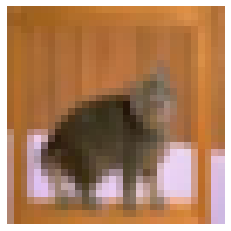

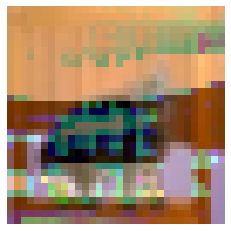

In [603]:
idx = 50
util.display_image(real_im[idx])
util.display_image(adv[idx])
print(classes[target[idx]])
print(classes[out_class[idx]])
print(classes[adv_class[idx]])
# print(classes[adv2_class[idx]])

In [447]:
class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features, num_classes):
        super().__init__()
        self.num_features = num_features
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        self.embed = nn.Embedding(num_classes, num_features * 2)
        self.embed.weight.data[:, :num_features].normal_(1, 0.02)  # Initialise scale at N(1, 0.02)
        self.embed.weight.data[:, num_features:].zero_()  # Initialise bias at 0

    def forward(self, x, y):
        out = self.bn(x)
        gamma, beta = self.embed(y).chunk(2, 1)
        out = gamma.view(-1, self.num_features, 1, 1) * out + beta.view(-1, self.num_features, 1, 1)
        return out

class ConditionalBatchNorm2d(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features
        num_filters = 128
        kernel_size = 3
        self.bn = nn.BatchNorm2d(num_features, affine=False)
        
        self.conv = nn.utils.spectral_norm(nn.Conv2d(num_features, num_filters, kernel_size=(kernel_size, kernel_size), padding=1))
        self.conv_gamma = nn.utils.spectral_norm(nn.Conv2d(num_filters, num_features, kernel_size=(kernel_size, kernel_size), padding=1))
        self.conv_beta = nn.utils.spectral_norm(nn.Conv2d(num_filters, num_features, kernel_size=(kernel_size, kernel_size), padding=1))

    def forward(self, x):
        out = self.bn(x)
        
        seg = F.relu(self.conv(x))
        seg_gamma = self.conv_gamma(seg)
        seg_beta = self.conv_beta(seg)
        
        print(seg_gamma.shape, seg_beta.shape)
        out = torch.matmul(seg_gamma, x) + seg_beta
        return out
    

    
bn = ConditionalBatchNorm2d(3)
z = torch.randn([1,3,224,224])
bn(z).shape


torch.Size([1, 3, 224, 224]) torch.Size([1, 3, 224, 224])


torch.Size([1, 3, 224, 224])